<a href="https://colab.research.google.com/github/oliveiravit/exercicio_pneumonia/blob/main/ExercicioPneumonia_PosFIAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Imagens Utilizando Deep Learning

Este projeto tem como objetivo desenvolver um modelo de Deep Learning para classificação de imagens,
utilizando redes neurais convolucionais (CNNs) com o framework TensorFlow/Keras.

## 1. Obtenção do Conjunto de Dados (Kaggle)

Nesta etapa, realizamos a configuração do ambiente para acesso à API do Kaggle e o download do dataset Chest X-Ray Images (Pneumonia), amplamente utilizado em estudos de visão computacional na área da saúde.

O acesso à API é realizado de forma segura por meio dos Secrets do Colab, evitando a exposição de credenciais sensíveis no código. A partir dessas credenciais, o arquivo kaggle.json é gerado dinamicamente para autenticação na plataforma.

Após a autenticação, o dataset é baixado e descompactado automaticamente no ambiente de execução, ficando disponível para as etapas subsequentes de pré-processamento e treinamento do modelo de Machine Learning.

In [2]:
!pip install kaggle --quiet

import os
import json
from google.colab import userdata

# Criar diretório de credenciais do Kaggle
os.makedirs("/root/.kaggle", exist_ok=True)

# Ler credenciais dos Secrets do Colab
kaggle_token = {
    "username": userdata.get("KAGGLE_USERNAME"),
    "key": userdata.get("KAGGLE_KEY")
}

# Criar arquivo kaggle.json dinamicamente
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_token, f)

# Ajustar permissões (obrigatório)
!chmod 600 /root/.kaggle/kaggle.json

# Baixar o dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p .

# Descompactar
!unzip -q chest-xray-pneumonia.zip

print("Dataset baixado com sucesso pela API do Kaggle")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.28G/2.29G [00:23<00:00, 247MB/s]
100% 2.29G/2.29G [00:23<00:00, 107MB/s]
Dataset baixado com sucesso pela API do Kaggle


## 2. Importação das Bibliotecas

Nesta etapa são importadas as bibliotecas necessárias para o processamento numérico, construção e treinamento do modelo de Machine Learning, manipulação de arquivos e visualização dos resultados.

Adicionalmente, é definida uma semente aleatória (random seed) no TensorFlow com o objetivo de garantir a reprodutibilidade dos experimentos. A fixação da semente contribui para a obtenção de resultados consistentes entre diferentes execuções, reduzindo variações decorrentes de processos aleatórios, como a inicialização dos pesos do modelo e o embaralhamento dos dados.

In [3]:
# Importações das bibliotecas
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#Definição da semente aleatória para garantir a reprodutibilidade dos resultados
tf.random.set_seed(4)

## 3. Definição dos caminhos dos conjuntos de dados

Nesta etapa são definidos os caminhos para os diretórios que contêm as imagens de raio-X, organizadas nos conjuntos de treinamento, validação e teste, conforme práticas consolidadas em projetos de Machine Learning.

A biblioteca pathlib é utilizada para a manipulação de caminhos de forma mais segura, legível e independente do sistema operacional. Essa separação dos dados possibilita o treinamento do modelo, o ajuste de hiperparâmetros e a avaliação do desempenho em dados não vistos, contribuindo para a redução do risco de overfitting.

In [4]:
# Criando os objetos Pathlib PATH
# Definição dos caminhos para os conjuntos de treinamento, validação e teste
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test")
test_path = Path("chest_xray/val")

## 4. Coleta dos caminhos das imagens

Nesta etapa são coletados os caminhos das imagens presentes nos conjuntos de treinamento, validação e teste, organizadas em subdiretórios correspondentes às classes Normal e Pneumonia.

A coleta é realizada por meio do método glob da biblioteca pathlib, que permite localizar arquivos com base em padrões de diretórios. O padrão "*/*" indica o acesso a todas as subpastas (classes) e aos arquivos de imagem nelas contidos.

O resultado é um objeto do tipo generator, que fornece os caminhos das imagens sob demanda, tornando o processo mais eficiente em termos de uso de memória.

In [5]:
# Coletando todos os caminhos dentro das pastas "Normal" e "Pneumonia" dos caminhos acima (caminhos das imagens de treinamento e validação)
# Os caminhos das imagens de treinamento e validação são coletados usando o método glob, que permite encontrar arquivos correspondentes a um padrão específico
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")
teste_image_paths = test_path.glob("*/*") #ANALISAR

# A saída é um objeto Generator
print(train_image_paths)

<generator object Path.glob at 0x7f15220a3670>


## 5. Conversão dos caminhos das imagens para listas

Após a coleta dos caminhos das imagens por meio do método glob, os resultados são retornados como objetos do tipo generator. Embora eficientes em termos de memória, esses objetos possuem limitações para operações como indexação, contagem de elementos e embaralhamento dos dados.

Dessa forma, os generators são convertidos em listas, permitindo maior flexibilidade no manuseio dos dados, como inspeção de exemplos, divisão dos conjuntos e análise exploratória do dataset. Cada elemento dessas listas é um objeto do tipo PosixPath, que representa o caminho completo até o arquivo de imagem.

In [6]:
# Converter objeto gerador em lista de elementos (conversão dos caminhos em listas)
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Agora as saídas são objetos "PosixPath"
print(train_image_paths[:3])

[PosixPath('chest_xray/train/NORMAL/IM-0495-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-1281-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0579-0001.jpeg')]


## 6. Conversão dos caminhos das imagens para strings

Nesta etapa, os caminhos das imagens, anteriormente representados como objetos do tipo PosixPath, são convertidos para o formato de strings, conforme exigido por diversas funções das APIs do TensorFlow e Keras para leitura e carregamento de arquivos.

A conversão é realizada por meio da função map, em conjunto com uma função lambda, aplicando a transformação de forma eficiente a todos os elementos da lista. Esse procedimento prepara o dataset para as etapas subsequentes do pipeline de pré-processamento e treinamento do modelo.

In [7]:
# Converter caminhos Posix em strings normais (conversão dos caminhos em strings)
train_image_paths = list(map(lambda x: str(x) , train_image_paths))
val_image_paths = list(map(lambda x: str(x) , val_image_paths))

print(train_image_paths[:3])

['chest_xray/train/NORMAL/IM-0495-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1281-0001.jpeg', 'chest_xray/train/NORMAL/IM-0579-0001.jpeg']


## 7. Verificação do tamanho dos conjuntos de dados

Nesta etapa é verificada a quantidade de imagens disponíveis nos conjuntos de treinamento e validação, permitindo compreender a dimensão do dataset utilizado.

Essa informação auxilia no planejamento de etapas posteriores, como a definição do batch size, do número de épocas de treinamento e na análise do balanceamento entre classes. O conhecimento do volume de dados também é fundamental para avaliar a capacidade de generalização do modelo e interpretar adequadamente os resultados obtidos durante o treinamento.

In [8]:
# Coletar comprimento para conjuntos de dados de treinamento e validação
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

## 8. Extração e codificação dos rótulos das imagens

Nesta etapa, os rótulos das imagens são extraídos automaticamente a partir da estrutura de diretórios do dataset, onde cada pasta representa uma classe (NORMAL ou PNEUMONIA). Essa abordagem dispensa o uso de arquivos adicionais de anotação e aproveita a organização nativa dos dados.

As classes são mapeadas para valores numéricos, possibilitando sua utilização no treinamento do modelo de Machine Learning. Adicionalmente, é criado um mapeamento inverso, permitindo a conversão de previsões numéricas em rótulos textuais, o que facilita a interpretação dos resultados.

In [9]:
# Toda imagem tem rótulo em seu caminho, então vamos cortá-la
LABELS = {'NORMAL': 0 , 'PNEUMONIA': 1}
INV_LABELS = {0: 'NORMAL', 1: 'PNEUMONIA'}

def get_label(path:str) -> int:
    return LABELS[path.split("/")[-2]]

# Obtenção das labels das imagens
# As labels das imagens são obtidas com base nos caminhos e são mapeadas para os rótulos numéricos correspondentes
train_labels = list(map(lambda x: get_label(x), train_image_paths))
val_labels = list(map(lambda x: get_label(x), val_image_paths))

print(train_labels[:3])

[0, 0, 0]


## 9. Criação do pipeline de dados e pré-processamento das imagens

Nesta etapa é definido o pipeline responsável pelo carregamento, pré-processamento e organização das imagens de raio-X para o treinamento do modelo de Deep Learning, utilizando a API tf.data do TensorFlow, que permite a construção de pipelines eficientes e escaláveis.

Inicialmente, é definido o batch size, que determina a quantidade de imagens processadas simultaneamente a cada iteração. Em seguida, é implementada uma função para carregamento das imagens a partir de seus caminhos, realizando a decodificação, o redimensionamento para um tamanho padrão e a aplicação de técnicas de data augmentation durante o treinamento.

Por fim, os caminhos das imagens e seus respectivos rótulos são organizados em um objeto tf.data.Dataset, no qual são aplicadas operações de embaralhamento, mapeamento das transformações e agrupamento em lotes, preparando os dados para a etapa de treinamento do modelo.

In [10]:
# Agora temos todos os caminhos de imagens de treinamento, validação e seus respectivos rótulos
# Definindo o tamanho do lote (BATCH_SIZE)
BATCH_SIZE = 32

# Função usada para Transformação
# Função para carregar e transformar as imagens
def load_and_transform(image, label, train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [224, 224], method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image, label

# Função usada para criar um objeto de dados Tensorflow
# Função para carregar e transformar as imagens:
def get_dataset(paths, labels, train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset, label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image, label: load_and_transform (image, label, train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

## 10. Criação e verificação do dataset de treinamento

Nesta etapa é criado o objeto tf.data.Dataset correspondente ao conjunto de treinamento, utilizando a função previamente definida para carregamento e pré-processamento das imagens. O tempo de execução dessa etapa é medido com o objetivo de avaliar o desempenho do pipeline de dados.

Em seguida, é realizada a verificação da estrutura do dataset por meio da inspeção do shape de um lote de imagens e de seus respectivos rótulos, assegurando que os dados estejam corretamente organizados e compatíveis com a entrada esperada pelo modelo de Deep Learning.

In [11]:
# Criando o objeto Train Dataset e verificando-o
# Criação do dataset de treinamento:
%time train_dataset = get_dataset(train_image_paths, train_labels)

# Verificação do shape de uma imagem e uma label do dataset de treinamento
image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 1.56 s, sys: 211 ms, total: 1.77 s
Wall time: 4.28 s
(32, 224, 224, 3)
(32,)


## 11. Visualização de uma amostra do conjunto de treinamento

Nesta etapa é realizada a visualização de uma imagem de exemplo do conjunto de treinamento, juntamente com seu respectivo rótulo. Essa análise visual permite verificar se as imagens foram corretamente carregadas, pré-processadas e associadas às classes correspondentes.

A conversão do rótulo numérico para sua representação textual facilita a interpretação dos dados e auxilia na identificação de possíveis inconsistências. Essa prática é especialmente relevante em projetos de visão computacional, pois contribui para a validação da qualidade do dataset e do pipeline de pré-processamento.

PNEUMONIA


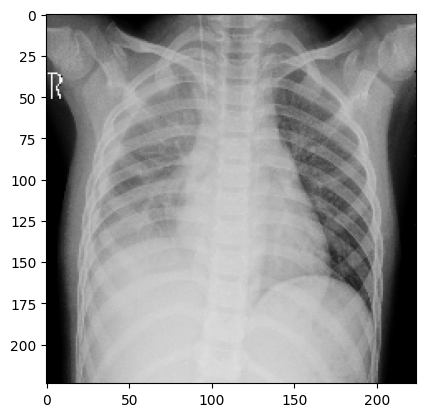

In [12]:
# Veja uma amostra de imagem de treinamento
# Exibição de uma imagem de exemplo
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

## 12. Criação e verificação do dataset de validação

Nesta etapa é criado o objeto tf.data.Dataset correspondente ao conjunto de validação, utilizando o mesmo pipeline de carregamento e pré-processamento definido para o conjunto de treinamento. Entretanto, as técnicas de data augmentation não são aplicadas, garantindo que a avaliação seja realizada sobre imagens que representam fielmente os dados originais.

Assim como no conjunto de treinamento, é realizada a verificação do shape das imagens e dos respectivos rótulos, assegurando que os dados estejam corretamente organizados e compatíveis com a arquitetura do modelo.

In [13]:
# Criação do dataset de validação
%time val_dataset = get_dataset(val_image_paths, val_labels, train = False)

# Verificação do shape de uma imagem e uma label do dataset de validação
image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 21.9 ms, sys: 0 ns, total: 21.9 ms
Wall time: 21.3 ms
(32, 224, 224, 3)
(32,)


## 13. Visualização de uma amostra do conjunto de validação

Nesta etapa é realizada a visualização de uma imagem do conjunto de validação, juntamente com seu respectivo rótulo, com o objetivo de verificar se os dados foram corretamente carregados, pré-processados e rotulados.

Essa inspeção também permite confirmar que técnicas de data augmentation não foram aplicadas nessa fase, garantindo que a avaliação do modelo ocorra sobre dados representativos e não alterados artificialmente, contribuindo para uma análise mais confiável do desempenho do modelo.

PNEUMONIA


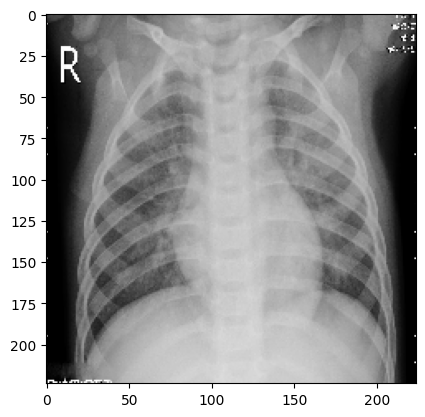

In [14]:
# Veja um exemplo de imagem de validação
# Exibição de uma imagem de exemplo
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

## 14. Construção do modelo utilizando Transfer Learning com ResNet50V2

Nesta etapa é realizada a construção do modelo de Deep Learning utilizando a arquitetura ResNet50V2 como backbone para extração de características, amplamente empregada em tarefas de classificação de imagens. A técnica de Transfer Learning é aplicada por meio da reutilização de pesos previamente treinados em grandes bases de dados.

Essa abordagem contribui para a redução do tempo de treinamento e para a melhoria da capacidade de generalização do modelo, especialmente em cenários com conjuntos de dados limitados, como aplicações médicas.

A camada final do modelo é adaptada para o problema de classificação binária, utilizando uma função de ativação sigmoide, que produz uma probabilidade associada à presença de pneumonia na imagem.

In [15]:
# Construindo o modelo ResNet50
# Criação do modelo utilizando a arquitetura ResNet50V2
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 23,521,409 (89.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

## 15. Compilação do modelo

Nesta etapa o modelo é compilado por meio da definição do otimizador, da função de perda e das métricas de avaliação, configurando a forma como o aprendizado ocorrerá durante o treinamento.

O otimizador Adam é empregado devido à sua eficiência e ampla utilização em tarefas de Deep Learning. A função de perda binary cross-entropy é utilizada por ser adequada a problemas de classificação binária, como a detecção de pneumonia em imagens de raio-X.

Além da acurácia, são consideradas as métricas de precisão e revocação (recall), especialmente relevantes em aplicações médicas, nas quais erros de classificação — como falsos negativos — podem acarretar impactos significativos.

In [16]:
# Compilando seu modelo fornecendo: Optimizer, Loss e Metrics
# Compilação do modelo
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name = 'precision'),tf.keras.metrics.Recall(name = 'recall')]
)

## 16. Definição de callbacks para controle do treinamento

Nesta etapa são definidos callbacks para monitorar e controlar automaticamente o processo de treinamento do modelo, contribuindo para maior eficiência e para a prevenção de overfitting.

O ModelCheckpoint é utilizado para salvar os pesos do modelo sempre que há melhoria no desempenho, garantindo a preservação da melhor versão treinada. Já o EarlyStopping é empregado para interromper o treinamento quando não ocorre melhora após um número pré-definido de épocas, evitando treinamentos desnecessários e possíveis degradações no desempenho do modelo.

In [17]:
# Definindo nossos retornos de chamada
# Definição de callbacks (checkpoint e early stop)
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.weights.h5", verbose=1, save_best_only = True, save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience = 4)

## 17. Treinamento do modelo

Nesta etapa é realizado o treinamento do modelo de Deep Learning utilizando os conjuntos de treinamento e validação previamente definidos. O treinamento ocorre de forma iterativa ao longo de múltiplas épocas, durante as quais os pesos do modelo são ajustados com o objetivo de minimizar a função de perda.

Devido ao uso de tf.data.Dataset com repetição infinita, é definido explicitamente o número de steps per epoch, garantindo uma quantidade consistente de amostras por época. O conjunto de validação é utilizado ao final de cada época para monitorar o desempenho do modelo em dados não vistos durante o treinamento.

Adicionalmente, são aplicados callbacks para salvar os melhores pesos do modelo e interromper o treinamento automaticamente na ausência de melhorias, tornando o processo mais eficiente e controlado.

In [18]:
# Treine o modelo
# Treinamento do modelo
history = model.fit(
    train_dataset,
    steps_per_epoch = train_dataset_length//BATCH_SIZE,
    epochs = 8,
    callbacks = [checkpoint, early_stop],
    validation_data = val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE,
)

Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9087 - loss: 0.2466 - precision: 0.9207 - recall: 0.9241
Epoch 1: val_loss improved from inf to 13.52112, saving model to best_weights.weights.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 151s 438ms/step - accuracy: 0.9089 - loss: 0.2461 - precision: 0.9209 - recall: 0.9243 - val_accuracy: 0.3783 - val_loss: 13.5211 - val_precision: 1.0000 - val_recall: 0.0131
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9662 - loss: 0.0908 - precision: 0.9800 - recall: 0.9733
Epoch 2: val_loss improved from 13.52112 to 3.44553, saving model to best_weights.weights.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 448ms/step - accuracy: 0.9662 - loss: 0.0908 - precision: 0.9800 - recall: 0.9734 - val_accuracy: 0.6201 - val_loss: 3.4455 - val_precision: 0.6194 - val_recall: 1.0000
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9745 - loss: 0.0773 - precision: 0.9818 - recall: 0.9833
Epoch 3: val_loss did not improve from 3

## 18. Análise e interpretação das métricas de desempenho

Nesta etapa são analisadas as métricas obtidas durante o treinamento por meio da visualização da evolução da acurácia, precisão, recall e da função de perda (loss) ao longo das épocas. A comparação entre os resultados de treinamento e validação permite avaliar o comportamento do modelo e identificar possíveis ocorrências de overfitting ou underfitting.

A análise gráfica dessas métricas é fundamental para compreender a dinâmica do aprendizado do modelo, auxiliando na validação de decisões relacionadas à arquitetura, ao número de épocas e ao uso de técnicas de regularização, como o early stopping.

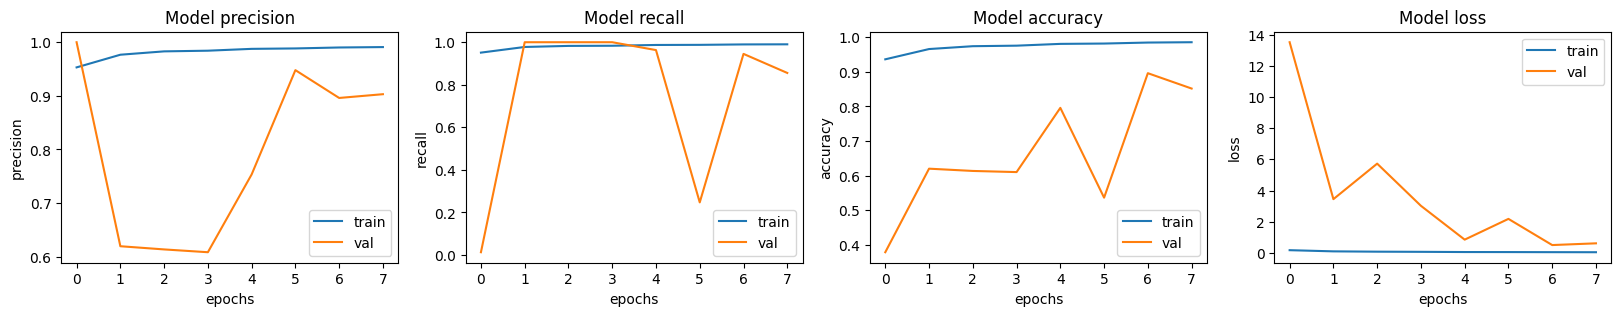

In [19]:
# Interpretando as Métricas
# Plotagem das métricas de treinamento (precisão, recall, acurácia e loss):
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 19. Carregamento e salvamento do melhor modelo treinado

Após a finalização do treinamento, são carregados os pesos do modelo salvos durante o processo por meio do callback ModelCheckpoint, configurado para armazenar apenas a versão com melhor desempenho no conjunto de validação. Essa etapa garante que o modelo utilize os parâmetros associados ao melhor equilíbrio entre erro e capacidade de generalização.

Em seguida, o modelo completo é salvo no formato HDF5 (.h5), que armazena a arquitetura da rede, os pesos treinados, o otimizador, a função de perda e as métricas utilizadas. Esse procedimento facilita a reutilização do modelo em etapas futuras, sem a necessidade de recompilação ou redefinição da estrutura.

Essa abordagem segue boas práticas em projetos de Deep Learning, contribuindo para a reprodutibilidade dos experimentos, a avaliação posterior do modelo e sua possível aplicação em ambientes de produção.

In [20]:
# Salvando o melhor modelo

# Carregue os melhores pesos
# Carregamento dos melhores pesos salvos
model.load_weights("best_weights.weights.h5")

# Salve todo o modelo (pesos + arquitetura)
# Salvando do modelo
model.save("model.h5")

## 20. Carregamento do modelo treinado

Nesta etapa, o modelo previamente salvo no formato .h5 é carregado por meio da função load_model do TensorFlow/Keras, restaurando integralmente sua arquitetura, pesos treinados, função de perda, otimizador e métricas.

Esse procedimento permite a reutilização imediata do modelo, sem a necessidade de redefinição ou recompilação, garantindo consistência entre o treinamento e seu uso posterior em avaliações, testes adicionais ou implantação em ambientes de produção.

O modelo carregado mantém exatamente o estado em que foi salvo, assegurando a reprodutibilidade dos resultados, prática fundamental em fluxos de trabalho de Machine Learning e Deep Learning.

In [21]:
# Carregando todo o modelo
# Carregamento do modelo salvo
loaded_model = tf.keras.models.load_model("model.h5")

## 21. Preparação do Dataset de Teste

Este bloco de código cria e prepara o dataset de teste para o modelo de deep learning. Primeiro, ele lista todos os caminhos das imagens dentro de `test_path`, percorrendo todas as subpastas, e converte cada caminho em string para compatibilidade com TensorFlow. Em seguida, aplica a função `get_label` para cada caminho de imagem, extraindo o rótulo correspondente (por exemplo, o nome da subpasta) e criando uma lista de labels. Essas listas de caminhos e labels são então convertidas em tensores, que são a estrutura de dados usada pelo TensorFlow.  

A função `decode_image` é definida para processar cada imagem: ela lê o arquivo de imagem, decodifica o JPEG em um tensor de pixels com 3 canais (RGB) e redimensiona a imagem para 224x224 pixels, compatível com modelos como ResNet50, retornando a imagem processada junto com seu rótulo. Por fim, o `Dataset` de teste é criado a partir dos tensores de caminhos e labels, aplica a função de decodificação a cada item e organiza os dados em **batches** do tamanho definido por `BATCH_SIZE`. Dessa forma, temos um dataset pronto para ser usado pelo modelo, com imagens processadas, labels correspondentes e organizadas para avaliação ou inferência.

In [22]:
# Crie um objeto de conjunto de dados para o conjunto 'Testing' da mesma forma que fizemos para treinamento e validação
# Preparação do dataset de teste
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x: str(x), test_image_paths))
test_labels = list(map(lambda x: get_label(x), test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

# Decodificação das imagens do dataset de teste
def decode_image(image, label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [224 , 224], method="nearest")
    return image, label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

## 22. Verificação do Dataset de Teste

Este trecho de código serve para inspecionar o dataset de teste que foi criado anteriormente. A linha `image, label = next(iter(test_dataset))` pega o primeiro lote (batch) de imagens e labels do dataset, transformando-o em iterador e retornando os tensores correspondentes.  

Em seguida, `print(image.shape)` exibe a forma (shape) do tensor de imagens, mostrando quantas imagens existem no batch e suas dimensões (altura, largura e número de canais). Já `print(label.shape)` mostra a forma do tensor de labels, confirmando quantos rótulos estão presentes no batch. Essa verificação é útil para garantir que o dataset foi criado corretamente, que as imagens estão no tamanho esperado e que os labels correspondem ao número correto de exemplos.

In [23]:
# Verificar objeto de conjunto de dados de teste
image, label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


## 23. Visualização de uma Imagem de Exemplo

Este trecho de código serve para **visualizar uma imagem do dataset** e conferir se está correta. A linha `print(INV_LABELS[label[0].numpy()])` exibe o **rótulo da primeira imagem do batch**, convertendo o tensor de label para valor numérico (`.numpy()`) e depois usando o dicionário `INV_LABELS` para mostrar o nome da classe correspondente.  

Em seguida, `plt.imshow(image[0].numpy().reshape(224, 224, 3))` exibe a imagem em si, convertendo o tensor de imagem para um array NumPy e garantindo que ela tenha a forma correta de altura, largura e canais de cor (224x224x3). Essa visualização é útil para verificar se o pré-processamento e redimensionamento das imagens foram aplicados corretamente antes de alimentar o modelo.


NORMAL


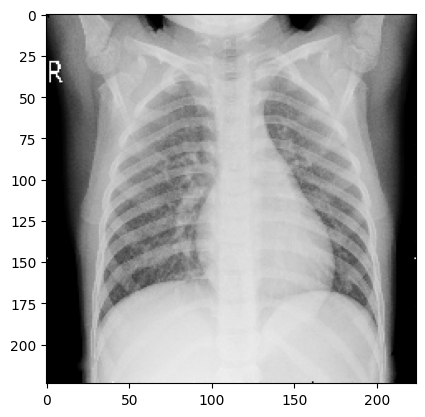

In [24]:
# Veja um exemplo de imagem de validação
# Exibição de uma imagem de exemplo
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

## 24. Avaliação do Modelo no Dataset de Teste

Este trecho de código realiza a avaliação do modelo previamente treinado e carregado usando o dataset de teste. A linha `loss, acc, prec, rec = loaded_model.evaluate(test_dataset)` calcula as métricas do modelo no conjunto de teste, retornando a função de perda (`loss`), acurácia (`acc`), precisão (`prec`) e recall (`rec`).  

Em seguida, os valores de acurácia, precisão e recall são impressos com `print`, permitindo verificar como o modelo está performando em dados que ele nunca viu antes. Essa avaliação é essencial para entender a capacidade de generalização do modelo e identificar se ele está funcionando bem fora do conjunto de treinamento.


In [25]:
# Avaliando o modelo carregado
# Avaliação do modelo no dataset de teste e impressão das métricas
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc: " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9375 - loss: 0.1697 - precision: 1.0000 - recall: 0.8750
 Testing Acc:  0.9375
 Testing Precision  1.0
 Testing Recall  0.875
